In [53]:
# Importing the required libraries
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

btc = pd.read_csv('BTC-USD.csv')
btc.index = pd.to_datetime(btc['Date'], format='%Y-%m-%d')
del btc['Date']

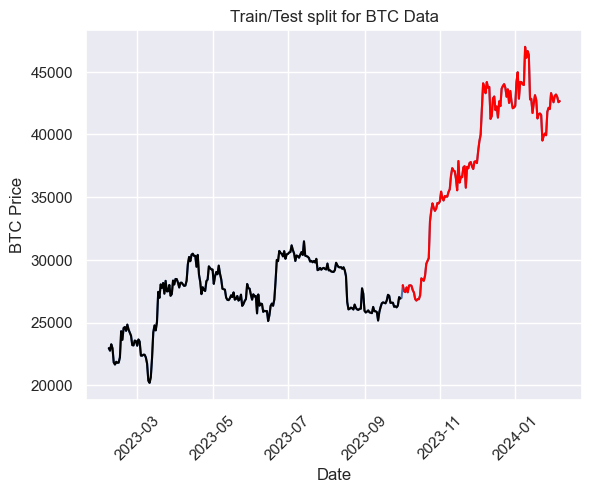

In [54]:
sns.set()

plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['Open'], )

train = btc[btc.index < pd.to_datetime("2023-10-01", format='%Y-%m-%d')]
test = btc[btc.index > pd.to_datetime("2023-10-01", format='%Y-%m-%d')]

plt.plot(train['Open'], color = "black")
plt.plot(test['Open'], color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

c:\Users\brand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\brand\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\brand\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Date
2023-10-02    26906.721608
2023-10-03    26899.590823
2023-10-04    26892.461927
2023-10-05    26885.334921
2023-10-06    26878.209803
2023-10-07    26871.086574
2023-10-08    26863.965233
2023-10-09    26856.845778
2023-10-10    26849.728211
2023-10-11    26842.612530
2023-10-12    26835.498735
2023-10-13    26828.386825
2023-10-14    26821.276799
2023-10-15    26814.168658
2023-10-16    26807.062401
2023-10-17    26799.958027
2023-10-18    26792.855536
2023-10-19    26785.754927
2023-10-20    26778.656200
2023-10-21    26771.559355
2023-10-22    26764.464390
2023-10-23    26757.371305
2023-10-24    26750.280100
2023-10-25    26743.190775
2023-10-26    26736.103328
2023-10-27    26729.017760
2023-10-28    26721.934069
2023-10-29    26714.852256
2023-10-30    26707.772319
2023-10-31    26700.694259
2023-11-01    26693.618075
2023-11-02    26686.543766
2023-11-03    26679.471332
2023-11-04    26672.400772
2023-11-05    26665.332086
2023-11-06    26658.265273
2023-11-07    26651.200

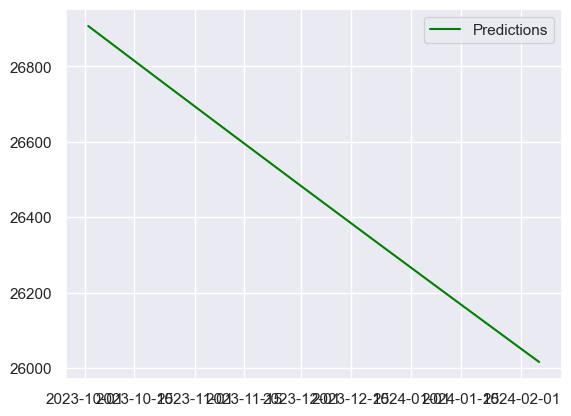

In [55]:

y = train['Open']
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(test['Open'].index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test['Open'].index
y_pred_out = y_pred_df["Predictions"]
print(y_pred_out)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test['Open'].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)